<a href="https://colab.research.google.com/github/bochap-opensource/ngms-careerday/blob/main/ngms_software_engineer_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
import asyncio
import cv2
import io
import ipywidgets as widgets
import logging
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from PIL import Image as PILImage
import requests
import sys
import time
from IPython.display import Audio, display, Image, clear_output, Video

logging.getLogger('matplotlib.font_manager').disabled = True

# Set the generic font family to monospace
plt.rcParams['font.family'] = 'monospace'

# Optionally, specify a list of desired monospace fonts to try
# Matplotlib will use the first one available on your system
plt.rcParams['font.monospace'] = ['Courier New', 'Roboto Mono', 'Ubuntu Mono', 'Andale Mono', 'DejaVu Sans Mono', 'DejaVu']
plt.rcParams['axes.unicode_minus'] = False  # Keep minus sign support


# Create the directory if it doesn't exist
data_dir = '/content/data'
os.makedirs(data_dir, exist_ok=True)

# URLs for the images (assuming they are in the same public GitHub repo)
base_url = "https://github.com/bochap-opensource/ngms-careerday/raw/main/data/"
for filename in ["security_key.png", "security_lock.png", "matrix_question_mark.png"]:
    url = base_url + filename
    key_path = os.path.join(data_dir, filename)
    if os.path.exists(key_path):  # Check if file already exists
      continue
    response = requests.get(url)
    if response.status_code == 200:
        with open(key_path, 'wb') as f:
            f.write(response.content)
    else:
        print(f"Failed to download {url}. Status code: {response.status_code}")


# --- HELPER FUNCTION FOR MISSION 4 ---
def show_intercepted_packet():
    # This creates a "Matrix Style" popup window using Python Code
    plt.figure(figsize=(6, 3))
    plt.gca().set_facecolor('black')

    # Draw the text with a glowing green effect
    plt.text(0.5, 0.6, "⚠️ ENCRYPTED DATA PACKET ⚠️",
             fontsize=14, color='lime', ha='center', fontname='foi', weight='bold')

    plt.text(0.5, 0.4, "FILE SIZE: 2 KB",
             fontsize=20, color='black', ha='center', fontname='monospace', weight='bold',
             bbox=dict(facecolor='#00FF00', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.axis('off') # Hide the math axes
    plt.title("/// SECURE TRANSMISSION ///", color='lime', fontsize=10, loc='left')
    plt.show()

#print("Image download process complete. Please re-run the Vault initialization cell now.")

# --- 🕵️ MISSION CONTROL CENTER (ASYNCIO) 🕵️ ---
# ==========================================
# FUNCTION 1: THE AUDIO TRANSMISSION (60s)
# ==========================================
def activate_mission_audio():
    """Generates and plays a synchronized 60-second background track."""
    print("📡 ESTABLISHING SECURE AUDIO LINK...", flush=True)

    rate = 22050
    bpm = 160
    beat_dur = 60 / bpm

    # 2 LOOPS = Exactly 60 seconds total runtime
    LOOP_COUNT = 3

    # --- SYNTHESIS ENGINES ---
    def smooth_tone(freq, dur, vol=0.1):
        if freq == 0: return np.zeros(int(rate * dur))
        t = np.linspace(0, dur, int(rate * dur), False)
        wave = np.sin(2 * np.pi * freq * t)
        fade_len = int(0.2 * rate * dur)
        if len(wave) > 2 * fade_len:
            wave[:fade_len] *= np.linspace(0, 1, fade_len)
            wave[-fade_len:] *= np.linspace(1, 0, fade_len)
        return wave * vol

    def shaker(dur, vol=0.015):
        noise = np.random.uniform(-1, 1, int(rate * dur))
        decay = np.linspace(1, 0, len(noise)) ** 2
        return noise * decay * vol

    # --- NOTES & PATTERNS ---
    G2, Bb2, C3, F2, Fs2 = 98.00, 116.54, 130.81, 87.31, 92.50
    G3, C4 = 196.00, 261.63
    G4, Bb4, C5, F4, Fs4 = 392.00, 466.16, 523.25, 349.23, 369.99

    def get_bass(variant='A'):
        d_long, d_short = beat_dur * 1.5, beat_dur * 1.0
        if variant == 'A': return np.concatenate([smooth_tone(G2, d_long), smooth_tone(G2, d_long), smooth_tone(Bb2, d_short), smooth_tone(C3, d_short)])
        return np.concatenate([smooth_tone(G2, d_long), smooth_tone(G2, d_long), smooth_tone(F2, d_short), smooth_tone(Fs2, d_short)])

    def get_melody(part):
        bar_len = int(rate * beat_dur * 5)
        if part == 'Silence': return np.zeros(bar_len)
        elif part == 'Theme_A':
            d = np.concatenate([smooth_tone(G4, beat_dur*3.0, 0.06), smooth_tone(Bb4, beat_dur*1.0, 0.06), smooth_tone(C5, beat_dur*1.0, 0.06)])
            return np.append(d, np.zeros(max(0, bar_len - len(d))))
        elif part == 'Theme_B':
            d = np.concatenate([smooth_tone(G4, beat_dur*3.0, 0.06), smooth_tone(F4, beat_dur*1.0, 0.06), smooth_tone(Fs4, beat_dur*1.0, 0.06)])
            return np.append(d, np.zeros(max(0, bar_len - len(d))))

    def get_bridge_bar():
        bar_len = int(rate * beat_dur * 5)
        d = np.concatenate([smooth_tone(G4, beat_dur*1.5, 0.05), smooth_tone(Fs4, beat_dur*1.5, 0.05), smooth_tone(F4, beat_dur*2.0, 0.05)])
        return np.append(d, np.zeros(max(0, bar_len - len(d))))

    def get_drums():
        hit = np.concatenate([shaker(beat_dur/2), np.zeros(int(rate * beat_dur/2))])
        return np.tile(hit, 5)

    # --- ARRANGEMENT ---
    # 1. INTRO
    seq_bass = np.concatenate([get_bass('A'), get_bass('B')] * 2)
    seq_melody = np.concatenate([get_melody('Silence')] * 4)
    seq_drums = np.concatenate([get_drums()] * 4)

    # 2. MAIN LOOPS
    block_bass = np.array([])
    block_melody = np.array([])
    block_drums = np.array([])
    for _ in range(2):
        block_bass = np.concatenate([block_bass, get_bass('A'), get_bass('B')]) if len(block_bass) else np.concatenate([get_bass('A'), get_bass('B')])
        block_melody = np.concatenate([block_melody, get_melody('Theme_A'), get_melody('Theme_B')]) if len(block_melody) else np.concatenate([get_melody('Theme_A'), get_melody('Theme_B')])
        block_drums = np.concatenate([block_drums, get_drums(), get_drums()]) if len(block_drums) else np.concatenate([get_drums(), get_drums()])
    for _ in range(2):
        block_bass = np.concatenate([block_bass, get_bass('A'), get_bass('B')])
        block_melody = np.concatenate([block_melody, get_bridge_bar(), get_bridge_bar()])
        block_drums = np.concatenate([block_drums, get_drums(), get_drums()])

    seq_bass = np.concatenate([seq_bass, np.tile(block_bass, LOOP_COUNT)])
    seq_melody = np.concatenate([seq_melody, np.tile(block_melody, LOOP_COUNT)])
    seq_drums = np.concatenate([seq_drums, np.tile(block_drums, LOOP_COUNT)])

    # 3. FINALE
    seq_bass = np.concatenate([seq_bass, smooth_tone(G2, 0.5), smooth_tone(G2, 0.5), smooth_tone(C3, 3.0)])
    seq_melody = np.concatenate([seq_melody, smooth_tone(G3, 0.5), smooth_tone(G3, 0.5), smooth_tone(C4, 3.0)])
    seq_drums = np.concatenate([seq_drums, np.zeros(int(rate * 4.0))])

    # MIX
    L = min(len(seq_bass), len(seq_melody), len(seq_drums))
    final_mix = (seq_bass[:L] + seq_melody[:L] + seq_drums[:L]) * 0.05 # 5% Volume

    display(Audio(final_mix, rate=rate, autoplay=True))


# ==========================================
# FUNCTION 2: THE TEXT TRANSMISSION (REDUCED CONTENT)
# ==========================================
async def display_mission_briefing():
    """Prints the story asynchronously using asyncio.sleep."""

    BOLD = "\033[1m"
    END = "\033[0m"

    # REDUCED TEXT (~50% shorter)
    message = f"""
Good day, {BOLD}Junior Software Engineers{END}.

I have received an urgent message from {BOLD}Principal Gilbert{END}.

It is {BOLD}3:40 PM{END}. The final bell rings in {BOLD}20{END} minutes.
The buses are waiting. The parents are waiting.
But the {BOLD}Master Key{END} is gone.

A notorious cyber-villain known only as {BOLD}'Dr. 67'{END} has hacked the school's vault.
Dr. 67 doesn't believe in summer break, weekends, or going home.
He wants school to last... {BOLD}forever{END}.

He trapped the key inside a {BOLD}Quantum Matrix Vault{END} protected by
6 layers of high-level encryption.

If we don't unlock this vault in the next 20 minutes, the bell will never ring.
You will be stuck here. The buses will leave without you.
And your parents? They will be circling the parking lot until they run out of gas.

This is where {BOLD}YOU{END} come in.

Dr. 67 made one mistake. He built his vault using {BOLD}Logic and Math{END}—
the two things he thought 7th graders didn't know how to use.

You are the Engineering Team. Your weapon is not a hammer or a laser...
it is {BOLD}Python Code{END}.

I have established a secure link to the vault.
Your mission, should you choose to accept it, is to write the code that
solves Dr. 67's riddles, breaks the encryption, and reveals the key to save the afternoon.

Open your laptops. Crack your knuckles.

{BOLD}Let's hack the vault.{END}
"""
    # Wait for audio to initialize
    await asyncio.sleep(2)

    # Title Animation
    print(f"\n{BOLD}⚠️  INCOMING TOP SECRET TRANSMISSION  ⚠️{END}", end="")
    for _ in range(3):
        await asyncio.sleep(0.5)
        print(".", end="")
        sys.stdout.flush()
    print("\n" + "="*45)

    # Typewriter Effect
    i = 0
    while i < len(message):
        if message[i:i+2] == '\033':
            end_code = message.find('m', i)
            if end_code != -1:
                print(message[i:end_code+1], end='')
                i = end_code + 1
                continue

        print(message[i], end='')
        sys.stdout.flush()

        # SPEED CALIBRATION
        # 0.04s per letter is slower/dramatic but safe because text is short
        if message[i] in [' ', '\n']:
            await asyncio.sleep(0.01)
        else:
            await asyncio.sleep(0.04)
        i += 1

    print("\n" + "="*45)
    print(f"{BOLD}END OF TRANSMISSION{END}")

def guess_the_software_engineer():
    # 1. THE IMAGE
    image_url = "/content/data/matrix_question_mark.png"

    # 2. THE LOCAL VIDEO PATH (The "Key")
    # In Colab, the default folder is /content/
    # Make sure to upload your .mp4 file to the folder icon on the left!
    video_path = "/content/mission_success.mp4"

    # Display the lock image
    #display(Image(url=image_url, width=500))
    display(PILImage.open(image_url))

    # --- STEP 2: WAIT FOR USER INPUT ---
    # This pauses the code until Enter is pressed
    input("")

    # --- STEP 3: CLEAR SCREEN & PLAY VIDEO ---
    clear_output(wait=True)

    time.sleep(1) # Dramatic pause

    # Play the local video file
    # 'embed=True' ensures it plays nicely within the browser
    display(Video(video_path, width=600, embed=True, html_attributes="controls autoplay"))

# 🎤 Career Day: The Code Detective & The Career Game

---

Before I introduce myself, I have a question. When I say 'Software Engineer,' what is the first thing that pops into your head?

<img src="https://github.com/bochap-opensource/ngms-careerday/blob/main/data/matrix_question_mark.png?raw=true" width="100%" />

## 1. HELLO WORLD: Expectation vs. Reality 🕶️ vs 🌍

**"I have good news and bad news."**

The **bad news** is... despite what you see in movies, I don't know Kung Fu, I don't live in the Matrix, and I can't hack the Pentagon in 10 seconds.

The **good news** is that the stereotype of a Software Engineer is totally wrong.

* ❌ **Stereotype:** You think we work alone in dark basements and never talk to humans.
* ✅ **Reality:** I spend half my day talking to people! My job is to solve their problems. If I can't understand people, I can't write code for them.

* ❌ **Stereotype:** You think we are stuck at a desk all day.
* ✅ **Reality:** My job is a **Passport**. It has taken me to live in **Japan** and the **USA**, experiencing different cultures and eating amazing food—all because the language of code is global.

---

## 2. THE BIO: The Human-to-Machine Translator 🗣️➡️💻

"So, hi everyone. I’m **Darren**, and I’m a Software Engineer.

You probably think that means I just type `1`s and `0`s until my eyes cross. But actually, I’m a professional **Problem Solver**.

Think of me as a **Translator**.
My job isn't just 'writing code.' It’s listening to humans who have big, messy problems, and then using logic and tools to explain those problems to a computer so it can fix them.

> I take *'I wish this app did X'* and turn it into the machine language that makes it happen.

My coding journey has taken me everywhere. Before I started saving lives with code, I solved problems in:
* 🛍️ **Ecommerce:** Building the systems that let you buy cool stuff online (so it actually arrives at your house).
* 💸 **Finance:** Writing code that moves money around the world faster than you can blink.
* 📱 **Big Tech:** I've even worked at those fancy tech giants that build the social media apps you use every day.

---

## 3. THE IMPACT: Coding to Save Lives 🧬

<img src="https://github.com/bochap-opensource/ngms-careerday/blob/main/data/genedx-logo.png?raw=true" width="200" />

"But right now, I'm doing something even cooler. Did you know that code can actually **save lives**?

I work at a company called **GeneDx**. We are like detectives, but instead of looking for fingerprints at a crime scene, we look at **DNA** to help doctors figure out why someone might be sick with a rare condition.

* **I Build the 'Super-Tools' 🛠️:** DNA is made up of *billions* of tiny pieces of information. No human could read through it all! I write the code that acts like a super-powered search engine for doctors.
* **I Manage the 'Big Data' 📊:** We have run over **2.5 million tests**. I build the systems that keep that mountain of data safe and organized.
* **I Speed Up Answers ⏱️:** My code helps analyze data faster, helping families get answers so they can start the right treatment sooner.

---

## 4. LEVEL UP: The Career Video Game 🎮

"So, how does a career in tech actually work? Think of it like an RPG video game. You start at Level 1, but as you gain XP (experience), you unlock new paths."

### **Level 1: The 'Newbie' (Junior Engineer) 🐣**
You are just learning the controls. You break things. You ask a million questions. You have a mentor who stops you from accidentally deleting the database.

### **Level 2: The 'Senior' (Pro Player) 🥋**
You know what you're doing. You can build entire features by yourself, and now *you* are the one helping the Newbies.

### **THE FORK IN THE ROAD 🔀**
Once you master the basics, you get to choose your Character Class:

**Path A: The Master Wizard (Technical Track) 🧙‍♂️**
* **Staff -> Distinguished Engineer**
* You don't want to be a boss. You just want to be the best coder in the world. You solve the hardest, craziest technical puzzles that no one else can figure out.

**Path B: The Guild Leader (Management Track) 🛡️**
* **Manager -> Senior Manager -> Director**
* You realize you like helping *people* more than writing code. You trade your keyboard for a clipboard. Your job is to build the ultimate team, make sure they have the right tools, and help them win.

### **Level 100: The Boss (C-Level) 👑**
Both paths lead to the top: **CTO (Chief Technology Officer)** or **CEO**. This is where you run the whole game.

---

## 5. THE CLOSE 🚀

"So, being a Software Engineer isn't just about sitting at a computer. It's about traveling the world, working in every industry from Finance to Big Tech, and even saving lives.

**If you like solving mysteries and want to speak the only language that everyone on Earth (and every robot) understands... you might just be a future engineer.**"

# 💻 LET THE FUN BEGIN: THE ENGINEER'S MINDSET

> ### **"Talk is cheap. Show me the code."**
> — *Linus Torvalds (Creator of Linux & Git)*

I've done a lot of talking. But to truly understand this job, you have to **experience** it.

In the real world, no single engineer builds a massive app like TikTok or Fortnite alone. That would be impossible. Instead, we treat engineering like a **Team Sport**.

### 🛠️ The Engineering Process:
1.  **Decomposition:** We take a huge, complex problem and break it down into tiny, solvable pieces.
2.  **Collaboration:** You solve one piece, your partner solves another.
3.  **Integration:** We combine our code together to create a solution that is bigger than the sum of its parts.

**Your Mission:**
We are going to simulate a real engineering sprint. You must work as a **Development Team** to write the code for each specific component.

Get ready to break it down, solve the pieces, and ship the code.


# 🕵️ THE MISSION BRIEFING

**STATUS:** `SECURE CONNECTION ESTABLISHED`
**SOURCE:** `PRINCIPAL'S OFFICE (ENCRYPTED)`
**PRIORITY:** `CRITICAL`

We have just intercepted a distress signal from the school administration. The situation is worse than we thought.

To understand the full scope of the threat, we need to decrypt the incoming message.

### 🔴 ACTION REQUIRED:
**Click the Play Button (▶️) on the code cell below to initialize the secure link and receive your mission objectives.**

In [2]:
# ==========================================
# EXECUTE MISSION BRIEFING
# ==========================================
# 1. Trigger Audio
activate_mission_audio()

# 2. Await the text transmission
await display_mission_briefing()

📡 ESTABLISHING SECURE AUDIO LINK...



⚠️  INCOMING TOP SECRET TRANSMISSION  ⚠️...

Good day, Junior Software Engineers.

I have received an urgent message from Principal Gilbert.

It is 3:40 PM. The final bell rings in 20 minutes.
The buses are waiting. The parents are waiting.
But the Master Key is gone.

A notorious cyber-villain known only as 'Dr. 67' has hacked the school's vault.
Dr. 67 doesn't believe in summer break, weekends, or going home.
He wants school to last... forever.

He trapped the key inside a Quantum Matrix Vault protected by 
6 layers of high-level encryption.

If we don't unlock this vault in the next 20 minutes, the bell will never ring.
You will be stuck here. The buses will leave without you.
And your parents? They will be circling the parking lot until they run out of gas.

This is where YOU come in.

Dr. 67 made one mistake. He built his vault using Logic and Math—
the two things he thought 7th graders didn't know how to use.

You are the Engineering Team. Your weapon is not a hammer or a laser.

# ⚙️ THE GAME ENGINE (DO NOT EDIT)

### 🤯 "Whoa, that looks complicated!"

If you are looking at the cell below and thinking, *"I have no idea what `cv2.resize` or `matplotlib.pyplot` means,"* **don't panic!**

This is exactly how it works in the real world. You don't write every single line of code from scratch. Instead, you build on top of **Libraries** and **Engines** written by more experienced engineers—like **Senior**, **Staff**, or **Distinguished Engineers**—or even **External Parties** (open source).

**Your job isn't to rewrite the engine—it's to use it to solve the problem.**

This block of code is the **Vault Engine**. It handles all the heavy lifting (graphics, encryption logic, and image processing) so you can focus on the Logic and Math.

⬇️ **ACTION:** Just hit the **Play Button (▶️)** on the cell below to boot up the system. You don't need to change a single line.

✅ Vault ONLINE. Security protocols active.


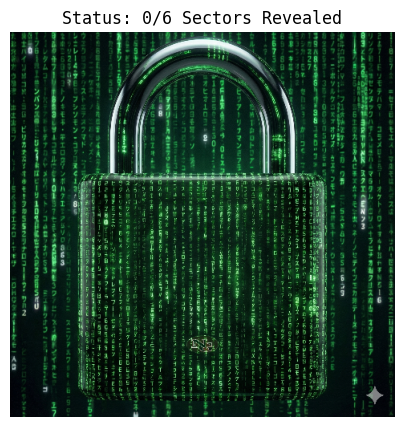

In [3]:
# --- THE GAME ENGINE (DO NOT EDIT THIS CELL) ---
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import time
from IPython.display import clear_output  # <--- IMPORTED FOR SCREEN WIPE EFFECT

class Vault:
    def __init__(self):
        # Paths to images in the local data folder
        # Make sure these paths are correct for your environment!
        self.secret_path = '/content/data/security_key.png'
        self.lock_path = '/content/data/security_lock.png'

        try:
            self.secret_img = mpimg.imread(self.secret_path)
            self.lock_img_raw = mpimg.imread(self.lock_path)

            dsize = (self.secret_img.shape[1], self.secret_img.shape[0])
            self.lock_img = cv2.resize(self.lock_img_raw, dsize)

            # Handle Transparency (Alpha Channel)
            if self.secret_img.shape[2] == 3:
                alpha = np.ones((self.secret_img.shape[0], self.secret_img.shape[1], 1), dtype=self.secret_img.dtype)
                self.secret_img = np.concatenate((self.secret_img, alpha), axis=2)

            if self.lock_img.shape[2] == 3:
                alpha = np.ones((self.lock_img.shape[0], self.lock_img.shape[1], 1), dtype=self.lock_img.dtype)
                self.lock_img = np.concatenate((self.lock_img, alpha), axis=2)

            self.display_img = self.lock_img.copy()
            self.rows, self.cols, _ = self.secret_img.shape
            self.r_step = self.rows // 3
            self.c_step = self.cols // 2
            self.unlocked_count = 0

            # Define the 6 sections of the image
            self.sections = {
                1: (0, self.r_step, 0, self.c_step),
                2: (0, self.r_step, self.c_step, self.cols),
                3: (self.r_step, self.r_step*2, 0, self.c_step),
                4: (self.r_step, self.r_step*2, self.c_step, self.cols),
                5: (self.r_step*2, self.rows, 0, self.c_step),
                6: (self.r_step*2, self.rows, self.c_step, self.cols),
            }
            print("✅ Vault ONLINE. Security protocols active.")
            self._display()
        except Exception as e:
            print(f"❌ CONNECTION ERROR: {e}")
            print("Check that your image paths are correct.")

    def check_code(self, challenge_number, student_answer, expected_answer):
        print(f"--- Verifying Security Clearance {challenge_number} ---")

        is_correct = False
        if isinstance(expected_answer, float):
             is_correct = abs(student_answer - expected_answer) < 0.01
        else:
             is_correct = student_answer == expected_answer

        if is_correct:
            print(f"ACCESS GRANTED. Decrypting Sector {challenge_number}...")
            r1, r2, c1, c2 = self.sections[challenge_number]
            self.display_img[r1:r2, c1:c2] = self.secret_img[r1:r2, c1:c2]
            self.unlocked_count += 1

            # --- MISSION 6 TRAP ---
            if challenge_number == 6:
                self._display()
                print("\n⚠️ SYSTEM ALERT: ANOMALY DETECTED!")
                time.sleep(2) # Pause so they see the success image briefly

                # --- THE FIX: WIPE THE SCREEN ---
                clear_output(wait=True)

                print("⚠️ SYSTEM ALERT: ANOMALY DETECTED!")
                print("Dr. 67 has triggered the 'Dead Man's Switch'...")
                time.sleep(1)

                # RE-LOCK THE VAULT
                self.display_img = self.lock_img.copy()
                self._display()

                print("❌ SYSTEM LOCKED.")
                print("---------------------------------------------------")
                print("HIDDEN MISSION: VISUAL DECRYPTION")
                print("Dr. 67 hid the password inside a visual data stream.")
                print("Analyze the graph below to find the algorithm.")
                print("---------------------------------------------------")
                self._generate_firewall_graph()
            else:
                self._display()
        else:
            print(f"ACCESS DENIED. Calculated: {student_answer}. Expected: {expected_answer}")

    def _generate_firewall_graph(self):
        # Create a Linear Graph (y = 3x + 5)
        x = np.array([0, 1, 2, 3, 4, 5])
        y = 3 * x + 5

        plt.figure(figsize=(6, 4))
        plt.plot(x, y, color='red', linewidth=3, marker='o', markersize=10, label='Encryption Key')

        # Grid settings
        plt.grid(True, which='both', linestyle='--', linewidth=0.7)
        plt.xticks(np.arange(0, 6, 1), fontfamily='monospace')
        plt.yticks(np.arange(0, 25, 5), fontfamily='monospace')

        # LABELS with generic monospace font (works on all machines)
        plt.xlabel("Input (x)", fontfamily='monospace', fontsize=12)
        plt.ylabel("Output (y)", fontfamily='monospace', fontsize=12)
        plt.title("FIREWALL DATA STREAM", fontfamily='monospace', fontsize=14, color='red')
        plt.legend(prop={'family': 'monospace'})
        plt.show()

    def check_final_boss(self, student_function):
        print("--- INJECTING CODE INTO FIREWALL ---")

        # We test their function against 3 different inputs
        test_inputs = [0, 2, 10]
        expected_outputs = [5, 11, 35]

        passed = True
        for i, val in enumerate(test_inputs):
            try:
                result = student_function(val)
                print(f"Testing Input {val}... Your Result: {result} | Expected: {expected_outputs[i]}")
                if result != expected_outputs[i]:
                    passed = False
                    break
            except Exception as e:
                print(f"❌ CODE ERROR: {e}")
                passed = False
                break

        if passed:
            print("\n🔥 SUCCESS! FIREWALL DESTROYED.")
            print("Restoring Master Key...")
            self.display_img = self.secret_img.copy()
            self._display()
            print("🎉 MISSION ACCOMPLISHED! The school day is saved!")
        else:
            print("\n❌ OVERRIDE FAILED. Your function does not match the graph.")
            print("Hint: Check the y-intercept (where the line starts) and the slope (rise over run).")

    def _display(self):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.display_img)
        plt.axis('off')

        # Check if we are in the "Trap" state
        if self.unlocked_count >= 6 and np.array_equal(self.display_img, self.lock_img):
             plt.title("SECURITY LOCKDOWN", fontfamily='monospace', color='red', weight='bold')
        else:
             plt.title(f"Status: {self.unlocked_count}/6 Sectors Revealed", fontfamily='monospace')
        plt.show()

# Initialize Game
vault = Vault()

✅ Vault ONLINE. Security protocols active.


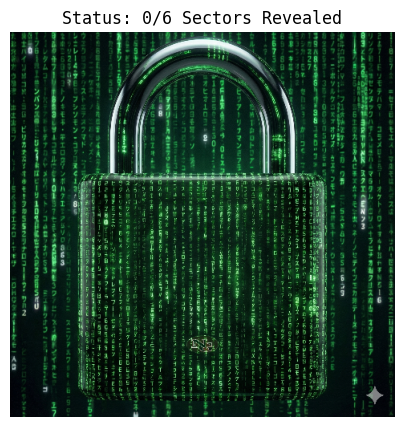

In [4]:
# --- THE GAME ENGINE (DO NOT EDIT THIS CELL) ---
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import time

class Vault:
    def __init__(self):
        # Paths to images in the local data folder
        # Make sure these paths are correct for your environment!
        self.secret_path = '/content/data/security_key.png'
        self.lock_path = '/content/data/security_lock.png'

        try:
            self.secret_img = mpimg.imread(self.secret_path)
            self.lock_img_raw = mpimg.imread(self.lock_path)

            dsize = (self.secret_img.shape[1], self.secret_img.shape[0])
            self.lock_img = cv2.resize(self.lock_img_raw, dsize)

            # Handle Transparency (Alpha Channel)
            if self.secret_img.shape[2] == 3:
                alpha = np.ones((self.secret_img.shape[0], self.secret_img.shape[1], 1), dtype=self.secret_img.dtype)
                self.secret_img = np.concatenate((self.secret_img, alpha), axis=2)

            if self.lock_img.shape[2] == 3:
                alpha = np.ones((self.lock_img.shape[0], self.lock_img.shape[1], 1), dtype=self.lock_img.dtype)
                self.lock_img = np.concatenate((self.lock_img, alpha), axis=2)

            self.display_img = self.lock_img.copy()
            self.rows, self.cols, _ = self.secret_img.shape
            self.r_step = self.rows // 3
            self.c_step = self.cols // 2
            self.unlocked_count = 0

            # Define the 6 sections of the image
            self.sections = {
                1: (0, self.r_step, 0, self.c_step),
                2: (0, self.r_step, self.c_step, self.cols),
                3: (self.r_step, self.r_step*2, 0, self.c_step),
                4: (self.r_step, self.r_step*2, self.c_step, self.cols),
                5: (self.r_step*2, self.rows, 0, self.c_step),
                6: (self.r_step*2, self.rows, self.c_step, self.cols),
            }
            print("✅ Vault ONLINE. Security protocols active.")
            self._display()
        except Exception as e:
            print(f"❌ CONNECTION ERROR: {e}")
            print("Check that your image paths are correct.")

    def check_code(self, challenge_number, student_answer, expected_answer):
        print(f"--- Verifying Security Clearance {challenge_number} ---")

        is_correct = False
        if isinstance(expected_answer, float):
             is_correct = abs(student_answer - expected_answer) < 0.01
        else:
             is_correct = student_answer == expected_answer

        if is_correct:
            print(f"ACCESS GRANTED. Decrypting Sector {challenge_number}...")
            r1, r2, c1, c2 = self.sections[challenge_number]
            self.display_img[r1:r2, c1:c2] = self.secret_img[r1:r2, c1:c2]
            self.unlocked_count += 1

            # --- MISSION 6 TRAP ---
            if challenge_number == 6:
                self._display()
                print("\n⚠️ SYSTEM ALERT: ANOMALY DETECTED!")
                time.sleep(1)
                print("Dr. 67 has triggered the 'Dead Man's Switch'...")
                time.sleep(1)

                # RE-LOCK THE VAULT
                self.display_img = self.lock_img.copy()
                self._display()

                print("❌ SYSTEM LOCKED.")
                print("---------------------------------------------------")
                print("HIDDEN MISSION: VISUAL DECRYPTION")
                print("Dr. 67 hid the password inside a visual data stream.")
                print("Analyze the graph below to find the algorithm.")
                print("---------------------------------------------------")
                self._generate_firewall_graph()
            else:
                self._display()
        else:
            print(f"ACCESS DENIED. Calculated: {student_answer}. Expected: {expected_answer}")

    def _generate_firewall_graph(self):
        # Create a Linear Graph (y = 3x + 5)
        x = np.array([0, 1, 2, 3, 4, 5])
        y = 3 * x + 5

        plt.figure(figsize=(6, 4))
        plt.plot(x, y, color='red', linewidth=3, marker='o', markersize=10, label='Encryption Key')

        # Grid settings
        plt.grid(True, which='both', linestyle='--', linewidth=0.7)
        plt.xticks(np.arange(0, 6, 1), fontfamily='monospace')
        plt.yticks(np.arange(0, 25, 5), fontfamily='monospace')

        # LABELS with generic monospace font (works on all machines)
        plt.xlabel("Input (x)", fontfamily='monospace', fontsize=12)
        plt.ylabel("Output (y)", fontfamily='monospace', fontsize=12)
        plt.title("FIREWALL DATA STREAM", fontfamily='monospace', fontsize=14, color='red')
        plt.legend(prop={'family': 'monospace'})
        plt.show()

    def check_final_boss(self, student_function):
        print("--- INJECTING CODE INTO FIREWALL ---")

        # We test their function against 3 different inputs
        test_inputs = [0, 2, 10]
        expected_outputs = [5, 11, 35]

        passed = True
        for i, val in enumerate(test_inputs):
            try:
                result = student_function(val)
                print(f"Testing Input {val}... Your Result: {result} | Expected: {expected_outputs[i]}")
                if result != expected_outputs[i]:
                    passed = False
                    break
            except Exception as e:
                print(f"❌ CODE ERROR: {e}")
                passed = False
                break

        if passed:
            print("\n🔥 SUCCESS! FIREWALL DESTROYED.")
            print("Restoring Master Key...")
            self.display_img = self.secret_img.copy()
            self._display()
            print("🎉 MISSION ACCOMPLISHED! The school day is saved!")
        else:
            print("\n❌ OVERRIDE FAILED. Your function does not match the graph.")
            print("Hint: Check the y-intercept (where the line starts) and the slope (rise over run).")

    def _display(self):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.display_img)
        plt.axis('off')

        # Check if we are in the "Trap" state
        if self.unlocked_count >= 6 and np.array_equal(self.display_img, self.lock_img):
             plt.title("SECURITY LOCKDOWN", fontfamily='monospace', color='red', weight='bold')
        else:
             plt.title(f"Status: {self.unlocked_count}/6 Sectors Revealed", fontfamily='monospace')
        plt.show()

# Initialize Game
vault = Vault()

# ⚡ MISSION 1: THE POWER SURGE

**STATUS:** `SYSTEM OFFLINE`
**OBJECTIVE:** `RESTART CORE PROCESSORS`

Dr. 67 has drained the power from the vault's intake system. To get the lock screen to appear, we need to send a precise surge of energy.

The system requires a base energy level of **15** plus an additional boost of **27**.

### 🐍 Engineering Concept: Basic Math
Python is an incredibly powerful calculator. You don't need to do the math in your head. You just need to tell Python what to calculate using standard math symbols:
* `+` (Add): 42 + 6
* `-` (Subtract): 42 - 6
* `*` (Multiply): 42 * 6
* `/` (Divide): 42 / 6

### 🎯 YOUR TASK:
1.  Look for the line that says `result = 0`.
2.  Change the `0` to the equation use the correct math symbbol shown in `Engineering Concept: Basic Math`.
3.  Run the cell to jumpstart the system.

--- Verifying Security Clearance 1 ---
ACCESS GRANTED. Decrypting Sector 1...


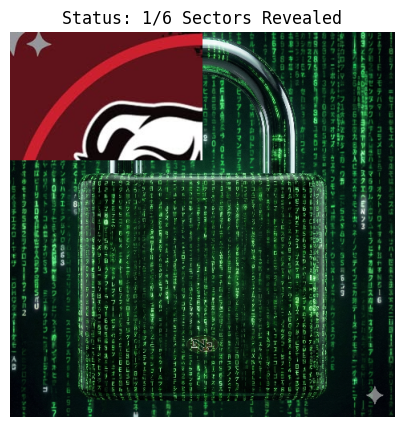

In [5]:
# === MISSION 1: INTAKE PROTOCOL ===
# The system needs a basic power surge to start.
# REQUIREMENT: Start with a base energy level of 15, and add 27 to it.

# 💡 HINT: In Python, we use the '+' symbol for addition.
# Example: result = 5 + 5

def calculate_total():
    # TODO: Erase the 0 and write the math to add 15 and 27
    result = 0 # <--- FIX THIS LINE
    result = 15 + 27
    return result

# Run security check
vault.check_code(1, calculate_total(), 42)

# 💾 MISSION 2: MEMORY ALLOCATION

**STATUS:** `MEMORY CORRUPTION DETECTED`
**OBJECTIVE:** `CLEAR DATA BLOCK`

We have hit a solid wall of corrupted memory. The system demands the exact total **Area** of this rectangular block before it can delete it.

You need to analyze the **Visual Schematic** below to find the dimensions.

<img src="https://github.com/bochap-opensource/ngms-careerday/raw/main/data/misson_2_corrupted_memory.png" width="400" />

### 🐍 Engineering Concept: Variables & Inputs
In this mission, you are not just using numbers; you are using **Variables**.
* **The Function:** Inside the function, we use the names `width` and `height` so the logic works for *any* rectangle.
* **The Inputs:** At the bottom, we feed the function the specific numbers from our data source (the image above).

### 🎯 YOUR TASK:
1.  **Fix the Logic:** Find `area = 0`. Change the `0` to the formula to calculate area of a rectangle.
2.  **Get the Data:** Look at the Green Matrix Image above to find the **Width** and **Height**.
3.  **Input the Code:** At the very bottom of the cell, change `width = 0` and `height = 0` to the actual numbers you found in the image.
4.  Run the cell to clear the corruption.

--- Verifying Security Clearance 2 ---
ACCESS GRANTED. Decrypting Sector 2...


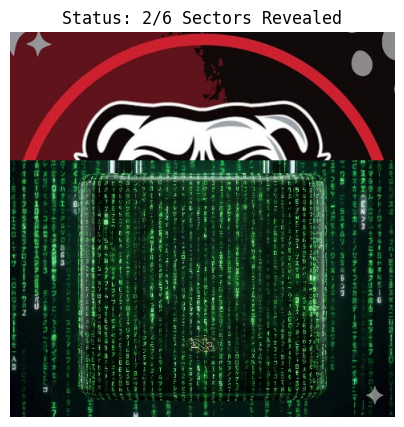

In [6]:
# === MISSION 2: MEMORY ALLOCATION ===
# We need to clear a rectangular block of memory in the system.
# REQUIREMENT: Calculate the AREA of the memory block that is ? units wide and ? units tall.

# 💡 HINT: The math formula for Area is Width times Height.
# In Python, the multiplication symbol is an asterisk: *
# Example: area = 5 * 5

def calculate_area(width, height):
    # TODO: Write the formula using the width and height variables
    area = 0 # <--- FIX THIS LINE
    area = width * height
    return area

# Run security check
width = 8 # <--- FIX THIS LINE
height = 9 # <--- FIX THIS LINE
vault.check_code(2, calculate_area(width, height), 72) #

# 🔐 MISSION 3: DECRYPTION LOGIC

**STATUS:** `SIGNAL SCRAMBLED`
**OBJECTIVE:** `UNSCRAMBLE KEY SEQUENCE`

We have located the next security key, but Dr. 67 has scrambled the signal. To unscramble it, we must process the numbers in a **very specific order**.

**The Algorithm:** Take the number **5**, add **3** to it, and *THEN* multiply that total result by **10**.

### 🐍 Engineering Concept: Order of Operations (PEMDAS)
Computers are very strict about Math rules. By default, Python will **always Multiply** before it **Adds**.

* `1 + 7 * 2` ❌
    * Python calculates `7 * 2` first (14), then adds 1. Result: **15**. (WRONG)
* `(1 + 7) * 2` ✅
    * Python sees the **Parentheses ( )** and calculates the inside first (8), then multiplies by 2. Result: **16**. (CORRECT)



### 🎯 YOUR TASK:
1.  Find the line `key = 0`.
2.  Translate the algorithm into Python code using `Engineering Concept: Order of Operations` as a reference
3.  **Crucial Step:** Make sure you use **Parentheses** `( )` to force the addition to happen first.
4.  Run the cell to decrypt the key.

--- Verifying Security Clearance 3 ---
ACCESS GRANTED. Decrypting Sector 3...


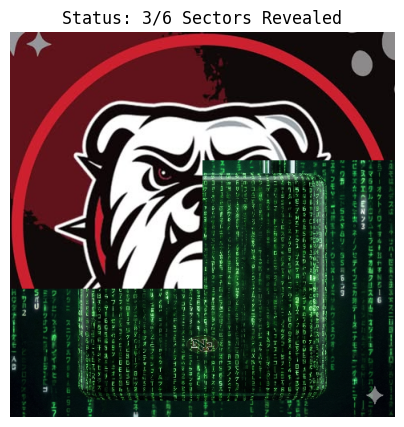

In [7]:
# === MISSION 3: DECRYPTION LOGIC ===
# The security key is scrambled. Follow the exact order to unscramble it.
# REQUIREMENT: Take the number 5, add 3 to it, AND THEN multiply that total result by 10.

# 💡 HINT: Computers follow PEMDAS. If you want addition to happen BEFORE
# multiplication, you must use parentheses ( ) around the addition part.
# Example: (2 + 2) * 5 is different than 2 + 2 * 5

def decrypt_key():
    # TODO: Write code to: (5 plus 3) times 10
    key = 0 # <--- FIX THIS LINE
    key = (5 + 3) * 10
    return key

# Run security check
vault.check_code(3, decrypt_key(), 80)

# 🔄 MISSION 4: THE DATA CONVERTER

**STATUS:** `INCOMPATIBLE FORMAT DETECTED`
**OBJECTIVE:** `CONVERT KB TO BYTES`

We have intercepted a data packet, but our system can't read it. It is measured in **Kilobytes (KB)**, but the vault requires **Bytes**.

To unlock this sector, you must follow this sequence:
1.  **Find the Data:** Run the scanner first to "intercept" the packet and see its size.
2.  **Write the Logic:** Create a translator that converts that size into Bytes.

### 🐍 Engineering Concept: Visual Debugging
In the real world, you don't always know your inputs ahead of time. Engineers build **Dashboards** to visualize live data.
In this mission, you will run a tool called `show_intercepted_packet()` that draws the intercepted data directly on your screen.

**The Conversion Fact:** $1 \text{ Kilobyte} = 1024 \text{ Bytes}$

### 🎯 YOUR TASK:
1.  **The Scan:** Run the code cell below **RIGHT NOW**. A **Green Matrix Popup** will appear.
2.  **The Input:** Read the **FILE SIZE** from that popup image.
3.  **The Variable:** Update `file_size = 0` (at the bottom of the cell) with that number.
4.  **The Logic:** Find `total_bytes = 0`. Replace the `0` with the math to multiply `file_size_kb` by **1024**.
5.  Run the cell again to complete the conversion.

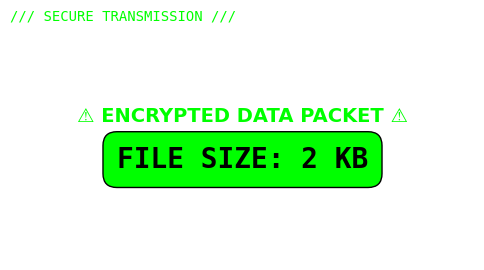

In [8]:
# --- 🔍 VISUAL SCAN ---
# Run this specific line below to see the intercepted image
show_intercepted_packet()

--- Verifying Security Clearance 4 ---
ACCESS GRANTED. Decrypting Sector 4...


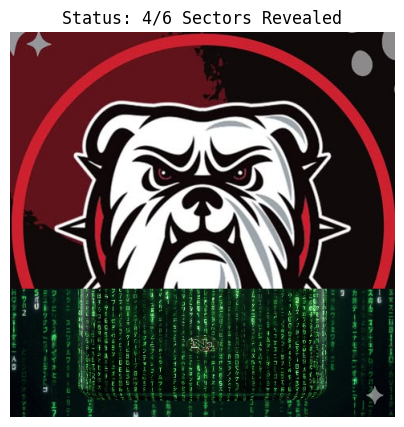

In [9]:
# === MISSION 4: THE DATA CONVERTER ===
# We intercepted a message, but it is in "Kilobytes" and the system needs "Bytes".
# REQUIREMENT: Convert the input size to Bytes.
# 1 Kilobyte = 1024 Bytes.

# 💡 HINT: In the function below, 'file_size_kb' is a VARIABLE.
# It acts as a placeholder for any number we send it.
# You just need to multiply that variable by 1024.

def convert_to_bytes(file_size_kb):
    # TODO: Multiply file_size_kb by 1024
    total_bytes = 0 # <--- FIX THIS LINE
    total_bytes = file_size_kb * 1024
    return total_bytes

# TODO: Look at the image above to find the File Size (in KB)
file_size = 0  # <--- ENTER THE NUMBER FROM THE IMAGE HERE
file_size = 2

# Run security check
vault.check_code(4, convert_to_bytes(file_size), 2048)

# ⚡ MISSION 5: THE QUADRATIC LOCK

**STATUS:** `EXPONENTIAL DECAY DETECTED`
**OBJECTIVE:** `SQUARE THE INPUT`

We have reached the heavy blast doors. They don't open with linear force; they require an **Exponential Surge**.

To open this lock, you must take the base number provided by the system and **Square it** (multiply it by itself).

### 🐍 Engineering Concept: Exponents (Power)
In math, you write $x^2$.
In Python, we use the double-asterisk operator `**`.
* **Wrong:** `input ^ 2` (This means something else in Python!)
* **Correct:** `input ** 2`

### 🎯 YOUR TASK:
1.  **The Logic:** Find `result = 0`. Replace the `0` with the Python code to raise `input_code` to the power of 2.
    * *Hint: Look at the "Engineering Concept" above to see which symbol to use.*
2.  **The Data:** Read the **"SYSTEM LOG"** in the code comments to find the **Base Number**.
3.  **The Input:** Update `base_number = 0` (at the bottom of the cell) with that number.
4.  Run the cell to blast open the doors.

--- Verifying Security Clearance 5 ---
ACCESS GRANTED. Decrypting Sector 5...


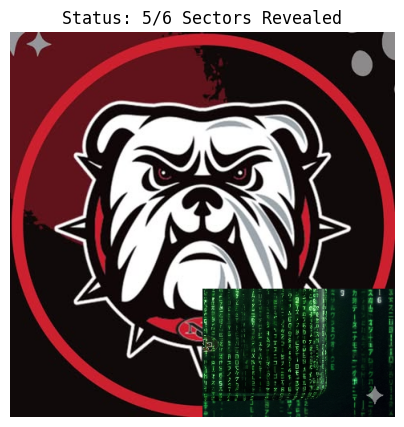

In [10]:
# === MISSION 5: THE QUADRATIC LOCK ===
# The security gate is controlled by an exponential algorithm.
# REQUIREMENT: We need to Square the input number (raise it to the power of 2).

# 💡 HINT: In Python, we don't use the caret symbol (^) for power.
# We use two asterisks: **
# Example: 5 squared is written as: 5 ** 2

def calculate_power(input_code):
    # TODO: Write the formula: input_code to the power of 2
    result = 0 # <--- FIX THIS LINE
    result = input_code ** 2
    return result

# --- SYSTEM LOG ---
# The gate is requesting the square of the following Base Number:
# > Base Number: 12

# TODO: Input the Base Number from the System Log above
base_number = 0 # <--- ENTER THE NUMBER FROM THE SYSTEM LOG HERE
base_number = 12

# Run security check
vault.check_code(5, calculate_power(base_number), 144)

# ⚖️ MISSION 6: NETWORK LOAD BALANCER

**STATUS:** `NETWORK SATURATION CRITICAL`
**OBJECTIVE:** `CALCULATE TOTAL BANDWIDTH`

This is the final lock. Dr. 67 has flooded our servers with junk traffic to hide the Master Key.
To clear the traffic, we must calculate exactly how much "Load" is on the network so we can balance it.

This mission tests everything you have learned: **Variables**, **Math**, and **Reading Logs**.

### 🐍 Engineering Concept: Weighted Calculations
Not all data is equal. Some data is "heavier" than others.
* **Video Streams** are heavy: They cost **50** units each.
* **Audio Streams** are light: They cost **10** units each.

To find the total load, you can't just add `videos + audios`. You must multiply each count by its **weight** first, and then sum them up.



### 🎯 YOUR TASK:
1.  **The Logic:** Find `total_load = 0`. Replace `0` with the math to calculate the total bandwidth.
    * *💡 Hint: Multiply `video_count` by 50 and `audio_count` by 10, then add the two results together using parentheses `( )`.*
2.  **The Data:** Read the **"SERVER INCIDENT LOG"** in the code comments to find the number of **Rogue Video Feeds** and **Dummy Audio Signals**.
3.  **The Input:** Update `videos = 0` and `audios = 0` (at the bottom of the cell) with those numbers.
4.  Run the cell to clear the network and reveal the final sector.

--- Verifying Security Clearance 6 ---
ACCESS GRANTED. Decrypting Sector 6...


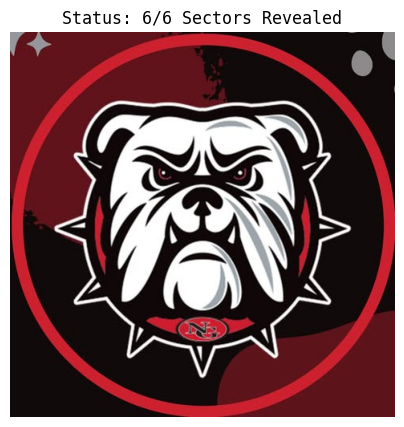


⚠️ SYSTEM ALERT: ANOMALY DETECTED!
Dr. 67 has triggered the 'Dead Man's Switch'...


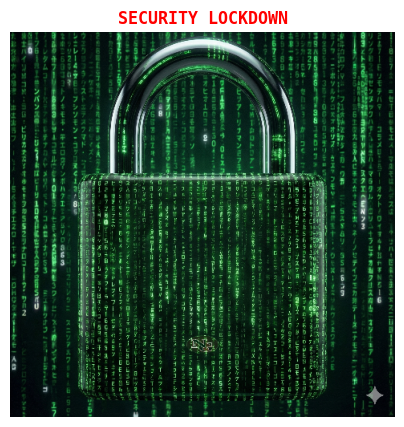

❌ SYSTEM LOCKED.
---------------------------------------------------
HIDDEN MISSION: VISUAL DECRYPTION
Dr. 67 hid the password inside a visual data stream.
Analyze the graph below to find the algorithm.
---------------------------------------------------


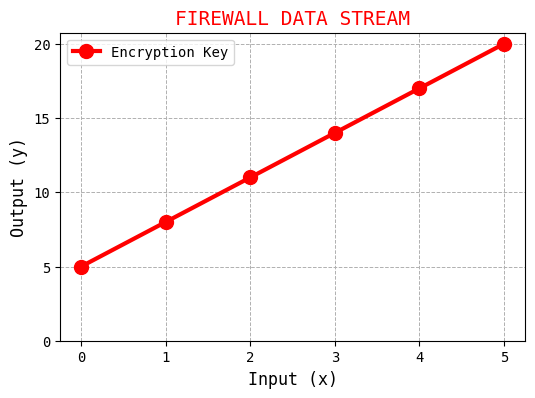

In [11]:
# === MISSION 6: NETWORK LOAD BALANCER ===
# The network is flooded. We need to calculate the total bandwidth usage.

# ENGINEERING SPECS (THE RULES):
# - Video Streams are HEAVY: They take up 50 units of bandwidth each.
# - Audio Streams are LIGHT: They take up 10 units of bandwidth each.

# REQUIREMENT:
# The formula is: (Video_Count times 50) PLUS (Audio_Count times 10)

def calculate_bandwidth(video_count, audio_count):
    # TODO: Write the formula using the variables provided above
    total_load = 0 # <--- FIX THIS LINE
    total_load = (video_count * 50) + (audio_count * 10)
    return total_load

# --- SERVER INCIDENT LOG ---
# We scanned the network and found the following active threats:
# > 4 Rogue Video Feeds detected
# > 12 Dummy Audio Signals detected

# TODO: Input the numbers from the Server Log above
videos = 0 # <--- ENTER THE NUMBER FROM THE SERVER INCIDENT LOG HERE
audios = 0 # <--- ENTER THE NUMBER FROM THE SERVER INCIDENT LOG HERE
videos = 4
audios = 12

# Run security check
vault.check_code(6, calculate_bandwidth(videos, audios), 320)

# 🚨 HIDDEN MISSION: VISUAL REVERSE ENGINEERING

**STATUS:** `SYSTEM LOCKED BY DEAD MAN'S SWITCH`
**OBJECTIVE:** `REVERSE ENGINEER THE ALGORITHM`

**IT WAS A TRAP!** When you completed the last mission, Dr. 67 triggered a "Dead Man's Switch," locking the vault and scrambling the code.

However, he left a trace. The **Red Graph** that just appeared on your screen reveals the mathematical pattern of the encryption.

To break this final firewall, you must **Reverse Engineer** the graph. You need to find the equation ($y = mx + b$) that matches the red line exactly.

### 🐍 Engineering Concept: Reading a Linear Graph
Instead of being told the numbers, you must find them in the visual data.

**1. Find the Y-Intercept ($b$):**
* Look at the vertical line (the Y-axis).
* Where does the Red Line start? (Where is the dot when $x$ is 0?)
* **That number is your `b`.**

**2. Find the Slope ($m$):**
* Look at the first dot and the second dot.
* How much does the line **RISE** (go up) when it moves over 1 step?
* *Example: If it goes from 5 to 8, the difference is 3.*
* **That difference is your `m`.**



### 🎯 YOUR TASK:
1.  **Analyze the Red Graph** generated above.
2.  Identify the starting number (**b**) and the step size (**m**).
3.  **Update the Code:** Inside the `break_firewall` function, change `m = 0` and `b = 0` to the numbers you found.
4.  Run the cell to destroy the firewall and save the school!

--- INJECTING CODE INTO FIREWALL ---
Testing Input 0... Your Result: 5 | Expected: 5
Testing Input 2... Your Result: 11 | Expected: 11
Testing Input 10... Your Result: 35 | Expected: 35

🔥 SUCCESS! FIREWALL DESTROYED.
Restoring Master Key...


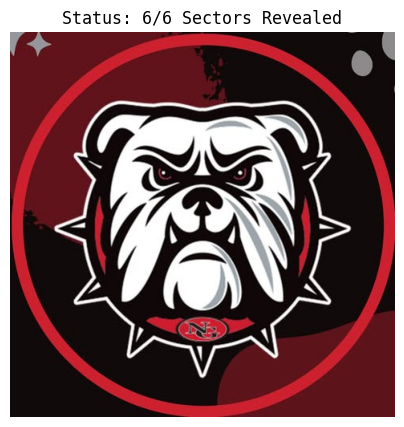

🎉 MISSION ACCOMPLISHED! The school day is saved!


In [12]:
# === 🚨 HIDDEN MISSION: VISUAL REVERSE ENGINEERING 🚨 ===
# The system is locked, but Dr. 67 left a trace: the RED GRAPH above.
# This graph represents the encryption key.

# YOUR TASK:
# 1. Look at the Red Graph above.
# 2. Find the Slope (m) -> How much does 'y' go up when 'x' moves over 1?
# 3. Find the Y-Intercept (b) -> Where does the line start on the vertical axis?
# 4. Write the Python code to match that line.

def break_firewall(x):
    # TODO: Change m and b to the numbers you found in the graph!
    m = 0 # <--- ENTER THE NUMBER FROM m here
    b = 0 # <--- ENTER THE NUMBER FROM b here
    m = 3
    b = 5

    # The linear equation formula
    y = (m * x) + b
    return y

# Run the final override
vault.check_final_boss(break_firewall)